## IMPORTS

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
from functions import train_index_updater
from functions import data_constructor
from functions import dataframe_generator
from functions import index_generator
from functions import load_labels

## SETTING UP PARAMETERS AND DIRECTORIES

In [3]:
SEED = 12
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 143778
VALID_SET= 25486
EPOCHS = 25
BS = 32
LR = 0.01
n=50000
label_file_train = "C:\project\data\\train_COVIDx_CT-2A.txt"
label_file_valid = "C:\project\data\\val_COVIDx_CT-2A.txt"

## LOADING DATA

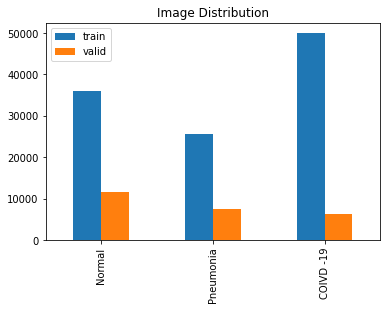

In [4]:
fnames_train , classes_train ,bboxes_train = load_labels(label_file_train)
fnames_valid , classes_valid ,bboxes_valid = load_labels(label_file_valid)
train_index = index_generator(fnames_train , TRAIN_SET)
valid_index = index_generator(fnames_valid , VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index,n )
df = dataframe_generator(train_index_updated, valid_index , classes_train , classes_valid)
df.plot.bar( title = "Image Distribution" );

## Loading Training and Validation Images

In [5]:
x_train, y_train = data_constructor(fnames_train,classes_train, DIM , index  =train_index_updated ,bboxes = bboxes_train )
x_valid , y_valid= data_constructor(fnames_valid,classes_valid, DIM , index  =valid_index , bboxes = bboxes_valid )

## Pre-Processing

In [6]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.05,width_shift_range=0.2 ,height_shift_range=0.1,shear_range=0.05)## ENTER YOUR AUG HERE
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [8]:
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(GlobalAveragePooling2D())
AlexNet.add(Dense(3))
AlexNet.add(Activation('softmax'))

In [9]:
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0

In [10]:
AlexNet.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models/AlexNet"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [12]:
r = AlexNet.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint]  )

  ...
    to  
  ['...']
Train for 3487 steps, validate on 25486 samples
Epoch 1/25
3487/3487 [==============================] - 497s 143ms/step - loss: 0.3230 - accuracy: 0.8724 - val_loss: 2.3736 - val_accuracy: 0.4457
Epoch 2/25
3487/3487 [==============================] - 486s 139ms/step - loss: 0.1915 - accuracy: 0.9302 - val_loss: 0.4798 - val_accuracy: 0.8077
Epoch 3/25
3487/3487 [==============================] - 509s 146ms/step - loss: 0.1556 - accuracy: 0.9444 - val_loss: 0.3578 - val_accuracy: 0.8540
Epoch 4/25
3487/3487 [==============================] - 532s 152ms/step - loss: 0.1342 - accuracy: 0.9524 - val_loss: 0.9777 - val_accuracy: 0.6666
Epoch 5/25
3487/3487 [==============================] - 463s 133ms/step - loss: 0.1181 - accuracy: 0.9578 - val_loss: 4.5425 - val_accuracy: 0.4100
Epoch 6/25
3487/3487 [==============================] - 461s 132ms/step - loss: 0.1057 - accuracy: 0.9628 - val_loss: 0.5506 - val_accuracy: 0.8205
Epoch 7/25
3487/3487 [=================

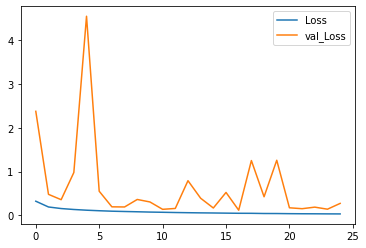

In [13]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

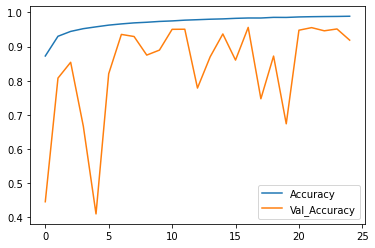

In [14]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [15]:
pd.DataFrame(r.history).to_csv("AlexNet.csv",index=False)

In [18]:
AlexNet.save("models/AlexNet/AlexNet.h5")